# GoogleNet

```{note}
我们该用什么样大小的卷积？GoogleNet说我全都要！<br/>
GoogleNet是2014年ImageNet比赛的冠军
```

## 结构

在GoogleNet中，基本的卷积块被称为Inception块，它由四条并行的通路组成，各自使用了不同大小的卷积核。

前3条通路的开头和第4条通路的末尾都是用了 $1\times{1}$ 的卷积核，那它究竟起什么作用呢？事实上与 $1\times{1}$ 卷积核卷积后，output是input各channel的线性组合，权重就是此 $1\times{1}$ 的卷积核各channel。在实际使用中，它主要起改变通道数的作用。

这4条通路都使用合理的参数使得输入和输出的高和宽一致，最后在通道维度上连接。

![jupyter](../images/d/inception.svg)

In [1]:
import torch
from torch import nn
import torch.nn.functional as F


class Inception(nn.Module):
    """
    GoogleNet中的Inception块
    自定义模块，主要定义好forward
    """
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        # c1到c4表示个路中的通道数
        super(Inception, self).__init__(**kwargs)
        # 1 x 1 卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 1 x 1 卷积层 + 3 x 3 卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 1 x 1 卷积层 + 5 x 5 卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 3 x 3 max-pooling层 + 1 x 1 卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        # 计算各通路
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在channels维度上连接起来
        return torch.cat((p1, p2, p3, p4), dim=1)

## 实现

下面实现我们简易版的GoogleNet。

In [2]:
# 开头是普通卷积层
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=5, padding=2), nn.ReLU(), 
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [3]:
# 第一段Inceptions
b2 = nn.Sequential(Inception(64, 32, (48, 64), (8, 16), 16),
                   Inception(128, 64, (64, 128), (16, 32), 32),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [4]:
# 第二段Inceptions
# Global AvgPool即全局池化层，将一个channel中所有点的平均值作为池化结果，即其output的高和宽均为1
# AdaptiveAvgPool2d((1, 1))的效果就是Global AvgPool
b3 = nn.Sequential(Inception(256, 128, (128, 256), (32, 64), 64),
                   Inception(512, 128, (128, 256), (32, 64), 64),
                   nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

In [5]:
# GoogleNet
net = nn.Sequential(b1, b2, b3, nn.Linear(512, 10))

In [6]:
X = torch.rand(size=(1, 1, 28, 28))
# 打印各部分的shape
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 14, 14])
Sequential output shape:	 torch.Size([1, 256, 7, 7])
Sequential output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


## 训练

In [7]:
import d2l

# 载入数据
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

loss 0.280, train acc 0.895967, test acc  0.890100


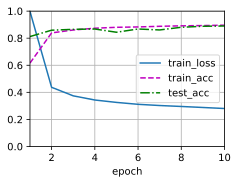

In [8]:
# 训练
lr, num_epochs = 0.01, 10
d2l.train_image_classifier(net, train_iter, test_iter, lr, num_epochs)